In [ ]:
from utils.pipelines import models_pipelines
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_score

import optuna

In [16]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

X_train = train_df.drop("class_encoded", axis=1)
y_train = train_df["class_encoded"]
X_test = test_df.drop("class_encoded", axis=1)
y_test = test_df["class_encoded"]

In [18]:
study_results = {}

def get_params_for_model(trial, model_name):
    params = {}

    n_features_max = X_train.shape[1]
    params['selection__k'] = trial.suggest_int("selection__k", 3, n_features_max)

    if model_name == 'SVC_Pipeline':
        params['model__C'] = trial.suggest_float("model__C", 1e-3, 100, log=True)
        params['model__gamma'] = trial.suggest_categorical("model__gamma", ["scale", "auto"])
        params['model__kernel'] = trial.suggest_categorical("model__kernel", ["rbf", "linear", "poly"])

    elif model_name == 'RandomForest_Pipeline':
        params['model__n_estimators'] = trial.suggest_int("model__n_estimators", 50, 400)
        params['model__max_depth'] = trial.suggest_int("model__max_depth", 3, 25)
        params['model__min_samples_split'] = trial.suggest_int("model__min_samples_split", 2, 15)

    elif model_name == 'KNN_Pipeline':
        params['model__n_neighbors'] = trial.suggest_int("model__n_neighbors", 3, 30)
        params['model__weights'] = trial.suggest_categorical("model__weights", ["uniform", "distance"])
        params['model__p'] = trial.suggest_categorical("model__p", [1, 2])

    elif model_name == 'XGBoost_Pipeline':
        params['model__n_estimators'] = trial.suggest_int("model__n_estimators", 50, 400)
        params['model__learning_rate'] = trial.suggest_float("model__learning_rate", 0.001, 0.3, log=True)
        params['model__max_depth'] = trial.suggest_int("model__max_depth", 3, 12)
        params['model__subsample'] = trial.suggest_float("model__subsample", 0.5, 1.0)


    elif model_name == 'QDA_Pipeline':
        params['model__reg_param'] = trial.suggest_float("model__reg_param", 0.0, 0.5)

    return params

    return params

n_trials_per_model = 10

print(f"Rozpoczynam optymalizację {len(models_pipelines)} modeli...")
print(f"Liczba prób na model: {n_trials_per_model}\n")

for name, pipeline in models_pipelines.items():
    print(f"--- Optimizing: {name} ---")

    def objective(trial):
        params = get_params_for_model(trial, name)

        pipeline.set_params(**params)

        cv = StratifiedKFold(n_splits=5, shuffle=True)

        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

        return scores.mean()

    study = optuna.create_study(direction="maximize", study_name=name)

    optuna.logging.set_verbosity(optuna.logging.WARNING)

    study.optimize(objective, n_trials=n_trials_per_model)

    print(f"Best Score: {study.best_value:.4f}")
    study_results[name] = study


Rozpoczynam optymalizację 6 modeli...
Liczba prób na model: 10

--- Optimizing: SVC_Pipeline ---
Best Score: 0.6499
--- Optimizing: RandomForest_Pipeline ---
Best Score: 0.7316
--- Optimizing: KNN_Pipeline ---
Best Score: 0.6464
--- Optimizing: XGBoost_Pipeline ---
Best Score: 0.7460
--- Optimizing: QDA_Pipeline ---
Best Score: 0.6297
--- Optimizing: SVC_OVR_Pipeline ---
Best Score: 0.6190


In [21]:
import pickle

results_data = []
for name, study in study_results.items():
    results_data.append({
        'Model': name,
        'Best_Accuracy': study.best_value,
        'Best_Params': study.best_params
    })

results_df = pd.DataFrame(results_data).sort_values(by='Best_Accuracy', ascending=False)
best_row = results_df.iloc[0]

best_model_name = best_row['Model']
best_params = best_row['Best_Params']

best_pipeline = models_pipelines[best_model_name]
best_pipeline.set_params(**best_params)
best_pipeline.fit(X_train, y_train)

filename = 'models/best_body_performance_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_pipeline, file)


C:\Users\Piotr Matusiewicz\Body-performance-analysis\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:39:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\Piotr Matusiewicz\Body-performance-analysis\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [03:34:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


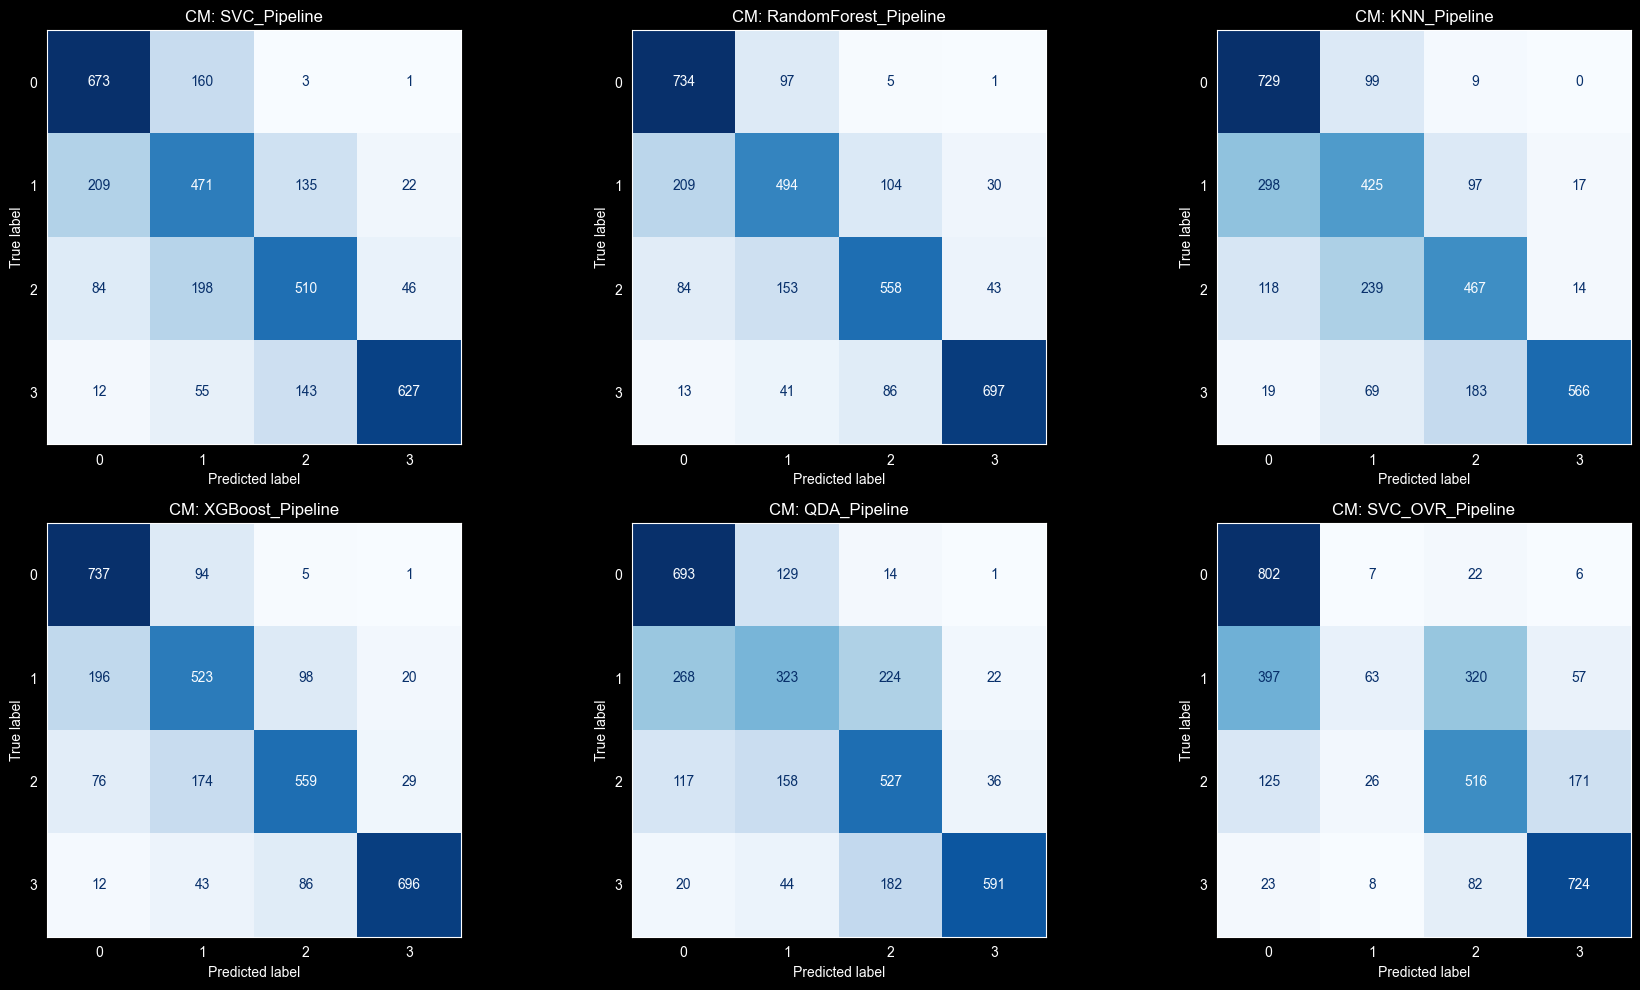

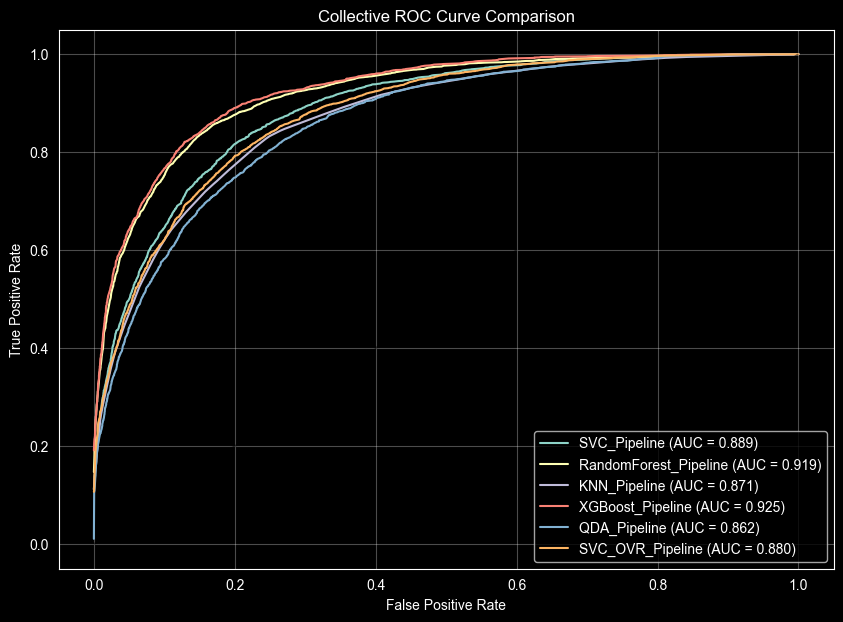

In [30]:
import math
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, f1_score, precision_score,
                             recall_score, roc_curve, auc)

metrics_summary = []
roc_data = {}
all_cm = []
n_classes = len(np.unique(y_train))

for model_name, study in study_results.items():
    pipeline = models_pipelines[model_name]
    pipeline.set_params(**study.best_params)

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    if hasattr(pipeline, "predict_proba"):
        y_proba = pipeline.predict_proba(X_test)
    else:
        y_proba = pipeline.decision_function(X_test)

    metrics_summary.append({
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred, average='weighted'),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted')
    })

    all_cm.append((model_name, confusion_matrix(y_test, y_pred)))

    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    roc_data[model_name] = (all_fpr, mean_tpr / n_classes, auc(all_fpr, mean_tpr / n_classes))

n_cols = 3
n_rows = math.ceil(len(all_cm) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, (name, cm) in enumerate(all_cm):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
    disp.plot(cmap='Blues', ax=axes[i], colorbar=False)
    axes[i].set_title(f'CM: {name}')
    axes[i].grid(False)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 7))
for name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Collective ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

summary_df = pd.DataFrame(metrics_summary).sort_values(by='F1 Score', ascending=False)

In [26]:
summary_df = pd.DataFrame(metrics_summary).sort_values(by='F1 Score', ascending=False)

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: darkgreen' if v else '' for v in is_max]

print("--- Tabela Porównawcza Wyników (Test Set) ---")
summary_df.style.apply(highlight_max, subset=['Accuracy', 'F1 Score', 'Precision', 'Recall']).format("{:.4}")

--- Tabela Porównawcza Wyników (Test Set) ---


,Model,Accuracy,F1 Score,Precision,Recall
3,XGBo,0.751,0.7509,0.7573,0.751
1,Rand,0.7414,0.7399,0.745,0.7414
0,SVC_,0.6811,0.6833,0.6916,0.6811
2,KNN_,0.653,0.6533,0.6757,0.653
4,QDA_,0.6372,0.6337,0.6477,0.6372
5,SVC_,0.6285,0.5639,0.6264,0.6285
